# Cavity Detection Tool (CADET)

## Import libraries

In [22]:
import os, sys, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import CCDData

from keras.models import load_model
from keras.layers import LeakyReLU

from sklearn.cluster import DBSCAN

from scipy.ndimage import center_of_mass, rotate

import warnings
warnings.filterwarnings("ignore")

import plotly.express as px
import plotly.graph_objects as go

## Function for producing 3D cavity models

In [37]:
def produce_3D_cavity(img, name="", plot=False):
    '''
    Function produces a 3D cavity model from 2D cavity prediction and calculates it's volume. The 3D model can be also alternatively plotted or stored in the .npy format.
    
    Input
    -----
    - two dimensional decomposed cavity prediction produced by the CADET network

    Parameters
    ----------
    img : 2D numpy array of size 128x128
        Two dimensional cavity prediction.
    name : string, optional
        Name of the 

    Returns
    -------
    volume : float
        Volume of the predicted cavity calculated under the assumption of rotational symmetry in every point along the direction from the galactic centre.

    Output (optional)
    ------
    - 3D cavity model stored in the .npy format
    - 3D cavity plot 
    '''

    # find the center of mass of the cavity and de-rotate it
    cen = center_of_mass(img)
    phi = np.arctan2(cen[0]-63.5, cen[1]-63.5)
    img = rotate(img, phi*180/np.pi, reshape=False, prefilter=False)

    # iterate over image slices and determine cavity width in each slice
    means, widths, indices = [], [], []
    for n in range(128):
        rang = np.where(img[:,n] > 0, np.arange(0,128), 0)
        if not (rang > 0).any(): continue
        x = 0
        for i,r in enumerate(rang):
            if r > 0 and x == 0: x = i
            elif x != 0 and r == 0: 
                widths.append((i-x)/2)
                means.append((x+i)/2)
                indices.append(n)
                x = 0
	
    # produce 3D cavity model
    cube = np.zeros((128,128,128))
    for m, w, i in zip(means, widths, indices):
        x, y = np.indices((128, 128))
        r = np.sqrt((x-abs(m))**2 + (y-63.5)**2)
        sliced = np.where(r <= w, 1, 0)
        cube[:,:,i] += sliced

    # (optional) plot 3D cavity model
    if plot:
        Zi,Xi,Yi = cube.nonzero()
        
        # fig = plt.figure()
        # ax = fig.add_subplot(111, projection='3d')
        # ax.plot(Xi,Yi,Zi, "sy", markersize=3, mec="k")
        # ax.plot(63.5, 63.5, 63.5, "or", ms=2)
        # ax.set_xlim(0,128)
        # ax.set_ylim(0,128)
        # ax.set_zlim(0,128)
        # ax.autoscale_view('tight')
        # fig.tight_layout()
        # plt.show()

        df = pd.DataFrame(list(zip(Xi,Yi,Zi)), columns=["x", "y", "z"])
        fig = px.scatter_3d(df, x='x', y='y', z='z')
        fig.update_layout(scene = dict(
                    xaxis = dict(nticks=4, range=[0,128],),
                    yaxis = dict(nticks=4, range=[0,128],),
                    zaxis = dict(nticks=4, range=[0,128],),),
                    width=700,
                    margin=dict(r=20, l=10, b=10, t=10))
        fig.update_traces(marker=dict(size=1.5, color="yellow", symbol="square",
                                      line=dict(width=1,
                                                color='DarkSlateGrey')),
                          selector=dict(mode='markers'))
        fig.show()


    # (optional) store the 3D cavity model in the .npy format
    if name: np.save("{0}.npy".format(name), cube)

    # return the cavity volume
    volume = np.sum(cube)
    return volume

## Usage


NGC5813
# AREA (px^2) VOLUME (px^3)
1 1721 70422
2 95 1516
3 95 1442
4 713 18244

NGC4778
# AREA (px^2) VOLUME (px^3)
1 50 910
2 549 15528
3 90 1800
4 874 28300

NGC4696
# AREA (px^2) VOLUME (px^3)
1 128 544
2 432 10338
3 349 8936
4 423 9254
5 438 11298


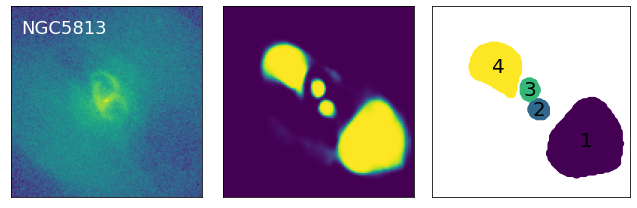

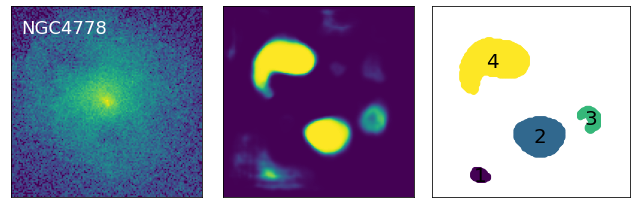

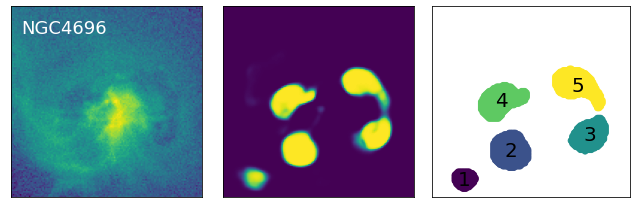

In [20]:
threshold = 0.55

# load the model
path_to_model = "CADET_size.h5"
if not os.path.exists(path_to_model):
    print("\nThere is no {0} file in the current directory".format(path_to_model))
model = load_model(path_to_model, custom_objects = {"LeakyReLU": LeakyReLU})

# find FITS files
files = glob.glob("example/*.fits")
if len(files) == 0:
    print("\nThe current directory does not seem to contain any FITS files.")
os.system("mkdir -p predictions decomposed txts")

# iterate over all FITS files
for filename in files:
    name = filename.split("/")[-1].split(".")[0]

    # load FITS file
    with fits.open(filename) as file:
        data = file[0].data
        wcs = WCS(file[0].header)

    # check the input shape
    shape = data.shape
    if shape != (128, 128):
        print("The image of size {0}x{1} is not supported. Please, transform your image into the 128x128 format.".format(*shape))
        continue

    # produce prediction
    data = np.log10(data+1) / np.amax(np.log10(data+1))
    pred = model.predict(data.reshape(1,128,128,1))
    pred = pred.reshape(128,128)
    ccd = CCDData(pred, unit="adu", wcs=wcs)
    ccd.write("predictions/{0}_CADET_size.fits".format(name), overwrite=True)

    # cut-off by the threshold and select nonzero points
    pred_cut = np.where(pred > threshold, pred, 0)
    x, y = pred_cut.nonzero()
    points = np.array([x,y]).reshape(2, -1)

    # decompose the prediction
    clusters = DBSCAN(eps=3).fit(points.T)
    clusters = clusters.labels_
    N = len(set(clusters))
    cavs, areas, volumes, xn, yn, clustersn = [], [], [], [], [], []
    for i in range(N):
        img = np.zeros((128,128))
        b = clusters == i
        xi, yi = x[b], y[b]
        img[xi,yi] = 1

        # ignore too small cavities
        if np.sum(img) < 30: continue
        
        xn = np.concatenate((xn, xi))
        yn = np.concatenate((yn, yi))
        clustersn = np.concatenate((clustersn, clusters[b]))

        cavs.append(img)
        areas.append(np.sum(img))
        volumes.append(produce_3D_cavity(img))
        #volumes.append(produce_3D_cavity(img, plot=True))#,name="{0}/{1}".format(dir,name))

    # save areas and volumes into txt file
    with open("txts/{0}_size.txt".format(name), "w") as file:
        print("\n{0}\n# AREA (px^2) VOLUME (px^3)".format(name))
        file.write("# AREA (px^2) VOLUME (px^3)")
        for i, area, volume in zip(range(len(areas)), areas, volumes):
            line = "{0} {1:.0f} {2:.0f}".format(i+1, area, volume)
            print(line)
            file.write("\n"+line)

    # plot decomposed predictions
    plt.figure(figsize=(9,3))
    plt.subplot(131)
    plt.text(35, 113, name, color="white", size=18, va="center", ha="center")
    plt.imshow(data, origin="lower")
    plt.xticks([]); plt.yticks([])

    plt.subplot(132)
    plt.imshow(pred, origin="lower")
    plt.xticks([]); plt.yticks([])

    plt.subplot(133)
    plt.scatter(yn, xn, c=clustersn, marker="o")
    for j,cav in enumerate(cavs):
        center = center_of_mass(cav)
        if not np.isnan(center[0]):
            plt.text(center[1], center[0], str(j+1), fontsize=20,
                        c="black", ha="center", va="center")
    plt.xticks([]); plt.yticks([])
    plt.xlim(0,128); plt.ylim(0,128)
    plt.tight_layout()
    plt.savefig("decomposed/{0}_CADET_size.png".format(name))

## 3D cavity model

In [38]:
produce_3D_cavity(img, plot=True);